# Polygon Colorization - Inference

Contents
1. Loading the trained UNet model for polygon colorization
2. Running inference on validation data
3. Testing with custom inputs

In [34]:
import os
os.chdir('/content/drive/MyDrive/unet')
os.getcwd()

'/content/drive/MyDrive/unet'

## 1. Setup and Imports

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from model import ConditionalUNet, COLOR_MAP, get_color_idx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load the Trained Model

In [ ]:
def load_model(checkpoint_path, device):
    """Load the trained model from checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Initialize model with same config as training
    model = ConditionalUNet(
        n_channels=3,
        n_classes=3,
        num_colors=len(COLOR_MAP),
        bilinear=checkpoint['config']['bilinear']
    )

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"Model loaded from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")
    return model

# Load the model
model_path = 'best_model.pth'
model = load_model(model_path, device)

Model loaded from epoch 98 with validation loss: 0.0352


## 3. Inference Functions

In [ ]:
def preprocess_image(image_path, img_size=256):
    """Preprocess input image for inference"""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0) # add batch dim
    return image_tensor

In [38]:
def postprocess_output(output_tensor):
    """Convert model output to displayable image"""
    # Remove batch dimension and convert to numpy
    output = output_tensor.squeeze(0).cpu().detach().numpy()
    # Transpose from CHW to HWC
    output = np.transpose(output, (1, 2, 0))
    # Clip values to [0, 1] range
    output = np.clip(output, 0, 1)
    return output

In [39]:
def colorize_polygon(model, image_path, color_name, device):
    """
    Generate colored polygon from input image and color name

    Args:
        model: Trained UNet model
        image_path: Path to input polygon image
        color_name: Name of the color (e.g., 'red', 'blue')
        device: PyTorch device

    Returns:
        Tuple of (input_image, output_image)
    """
    # Preprocess input
    input_tensor = preprocess_image(image_path).to(device)
    color_idx = torch.tensor([get_color_idx(color_name)], dtype=torch.long).to(device)

    # Generate prediction
    with torch.no_grad():
        output_tensor = model(input_tensor, color_idx)

    # Postprocess
    input_image = postprocess_output(input_tensor.cpu())
    output_image = postprocess_output(output_tensor)

    return input_image, output_image

## 4. Test on Validation Data

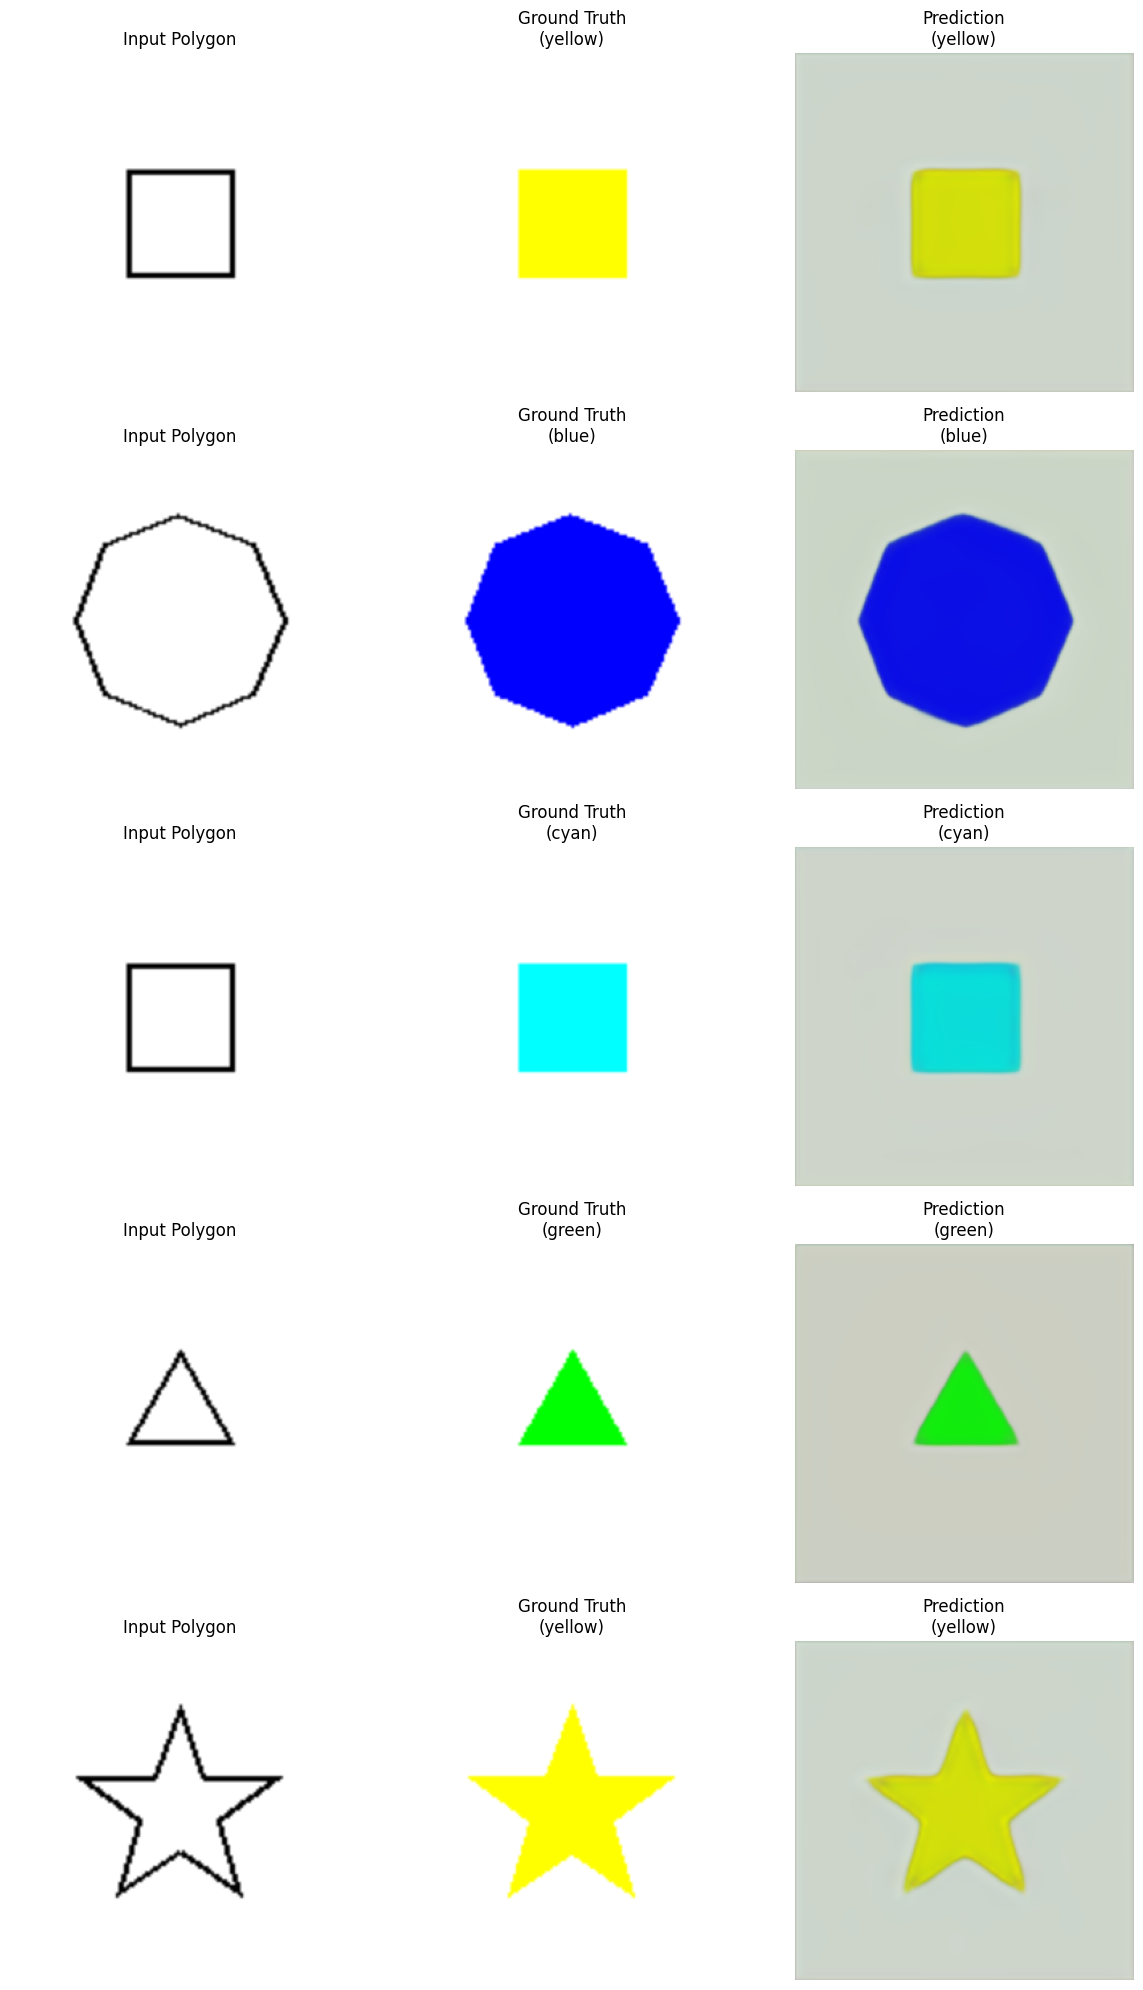

In [ ]:
def test_on_validation_data(model, val_json_path, val_input_dir, device, num_samples=5):
    """Test model on validation dataset"""
    # Load validation data
    with open(val_json_path, 'r') as f:
        val_data = json.load(f)


    import random
    samples = random.sample(val_data, min(num_samples, len(val_data)))

    fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4*len(samples)))
    if len(samples) == 1:
        axes = axes.reshape(1, -1)

    for i, sample in enumerate(samples):
        input_path = os.path.join(val_input_dir, sample['input_polygon'])
        color_name = sample['colour']

        # Generate prediction
        input_img, pred_img = colorize_polygon(model, input_path, color_name, device)

        # Load ground truth for comparison
        output_path = os.path.join(val_input_dir.replace('inputs', 'outputs'), sample['output_image'])
        if os.path.exists(output_path):
            gt_img = postprocess_output(preprocess_image(output_path))
        else:
            gt_img = np.zeros_like(pred_img)

        # Plot
        axes[i, 0].imshow(input_img)
        axes[i, 0].set_title('Input Polygon')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_img)
        axes[i, 1].set_title(f'Ground Truth\n({color_name})')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_img)
        axes[i, 2].set_title(f'Prediction\n({color_name})')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Test on validation data
val_json_path = 'dataset/validation/data.json'
val_input_dir = 'dataset/validation/inputs'

test_on_validation_data(model, val_json_path, val_input_dir, device, num_samples=5)

## 5. More Testing

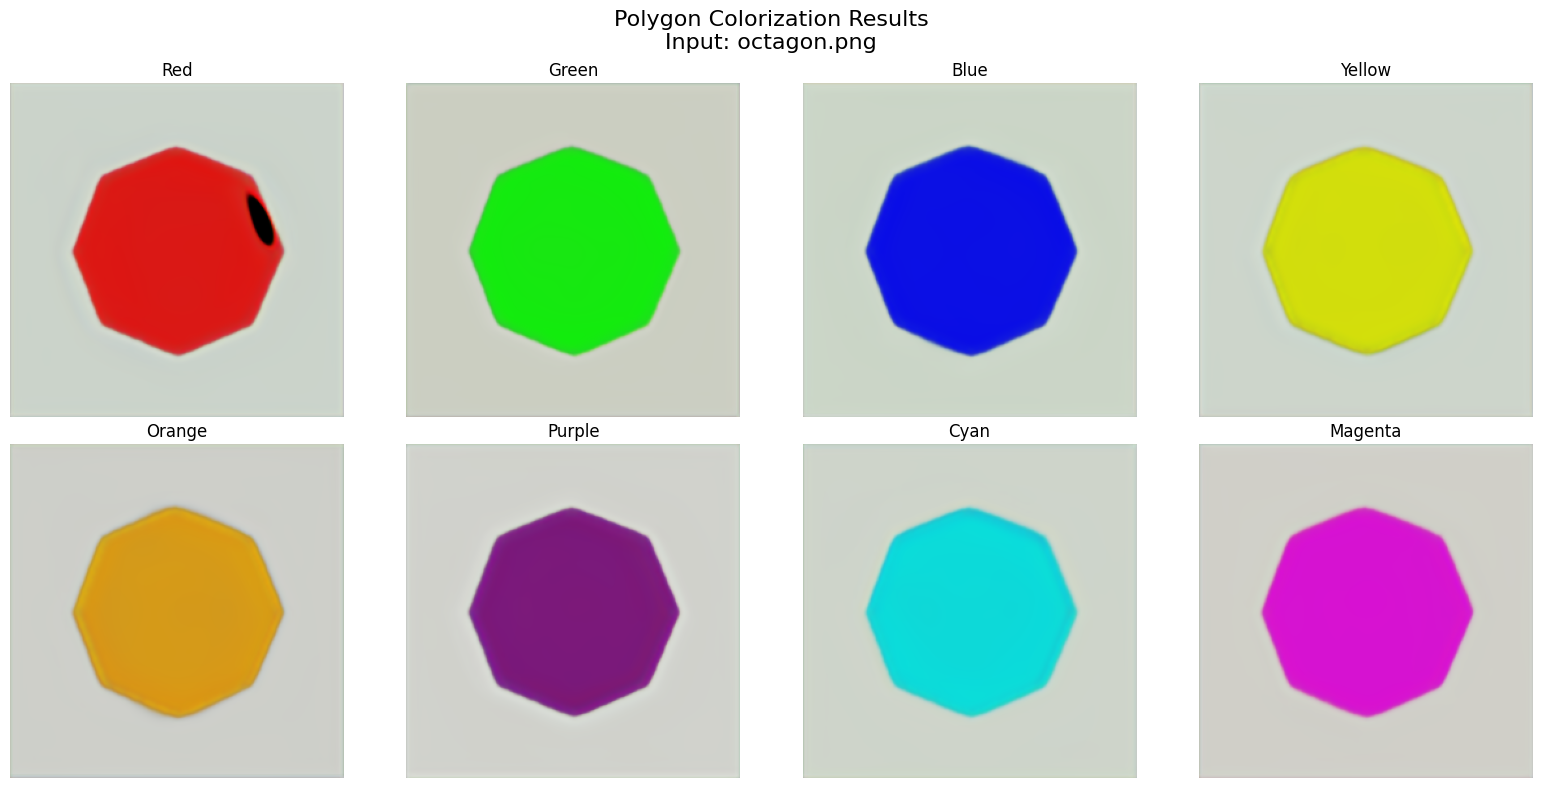

In [45]:
def interactive_colorization_demo(model, image_path, device):
    """
    Demonstrate colorization with all available colors
    """
    available_colors = list(COLOR_MAP.keys())

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, color in enumerate(available_colors):
        input_img, output_img = colorize_polygon(model, image_path, color, device)

        axes[i].imshow(output_img)
        axes[i].set_title(f'{color.capitalize()}')
        axes[i].axis('off')

    plt.suptitle(f'Polygon Colorization Results\nInput: {os.path.basename(image_path)}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage - update the path to an actual polygon image
example_image_path = 'dataset/validation/inputs/octagon.png'
if os.path.exists(example_image_path):
    interactive_colorization_demo(model, example_image_path, device)
else:
    print(f"Image not found: {example_image_path}")
    print("Please update the path to point to an actual polygon image.")

## 6. Custom Image Testing

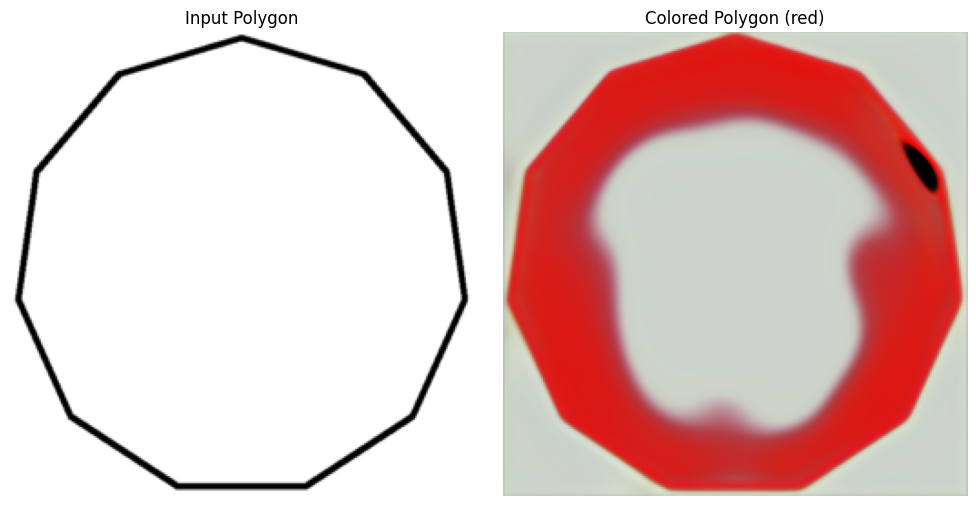

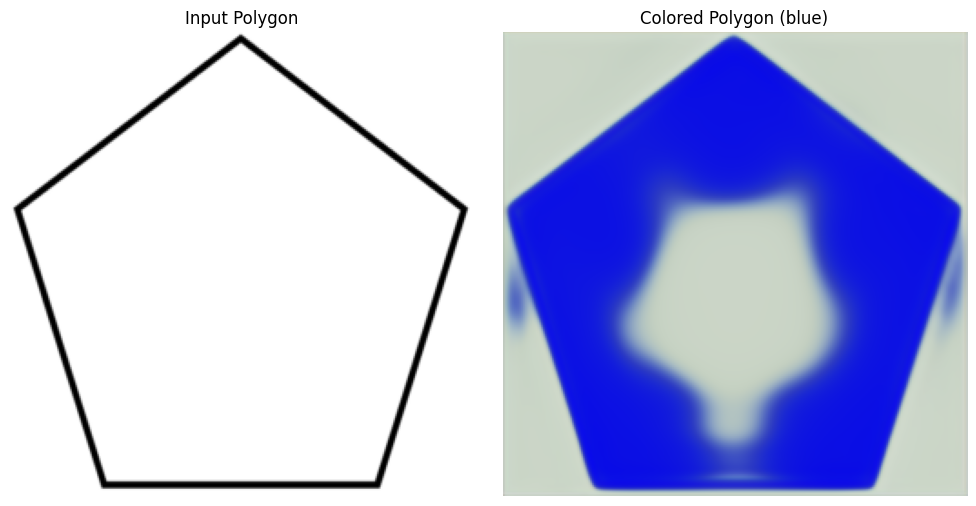

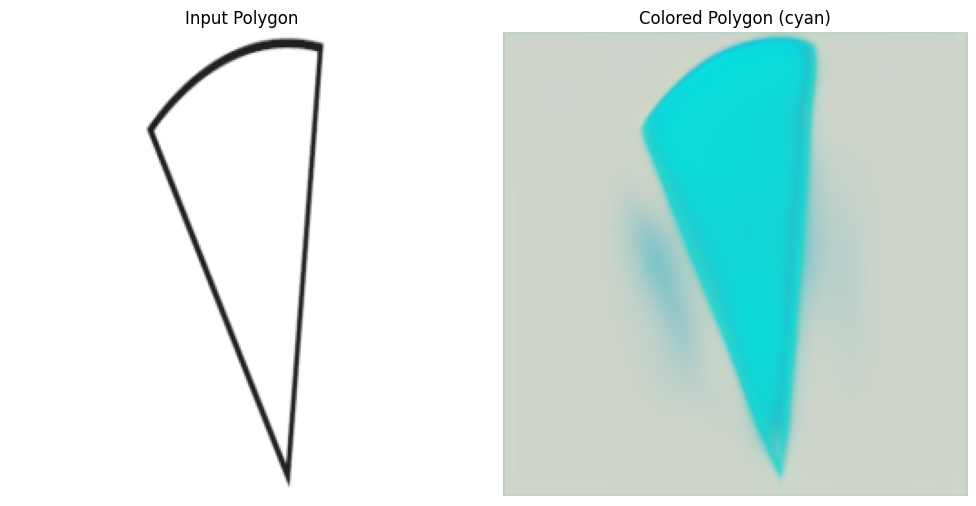

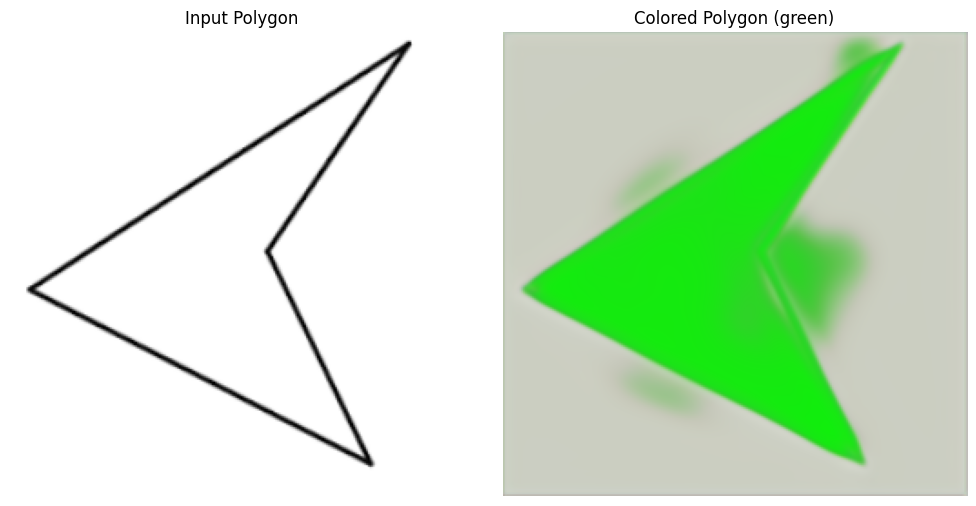

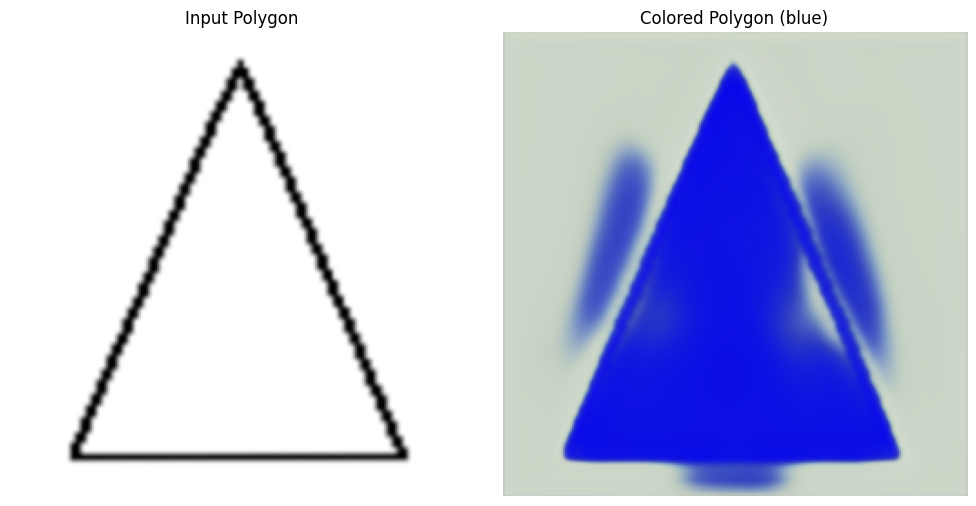

In [43]:
def test_custom_image(model, image_path, color_name, device):
    """
    Test the model on a custom image
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    if color_name.lower() not in COLOR_MAP:
        print(f"Color '{color_name}' not supported. Available colors: {list(COLOR_MAP.keys())}")
        return

    input_img, output_img = colorize_polygon(model, image_path, color_name, device)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(input_img)
    ax1.set_title('Input Polygon')
    ax1.axis('off')

    ax2.imshow(output_img)
    ax2.set_title(f'Colored Polygon ({color_name})')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Example custom test
test_custom_image(model, 'custom1.png', 'red', device)
test_custom_image(model, 'custom2.png', 'blue', device)
test_custom_image(model, 'custom3.png', 'cyan', device)
test_custom_image(model, 'custom4.png', 'green', device)
test_custom_image(model, 'custom5.png', 'blue', device)